In [36]:
from config import CONFIG
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
import math
import numpy as np
import pandas as pd
import sys

In [37]:
path = CONFIG['PATH']
pair = CONFIG['BASE'] + "/" + CONFIG['QUOTE']
one_day = 86400
sequence_length = 1
candlesticks = pd.read_csv(path + "/data/candlesticks.csv")
candlesticks = candlesticks[['date','open','high','low','close','volume','weightedAverage']]

In [40]:
def plot(df, title):
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

<IPython.core.display.Javascript object>


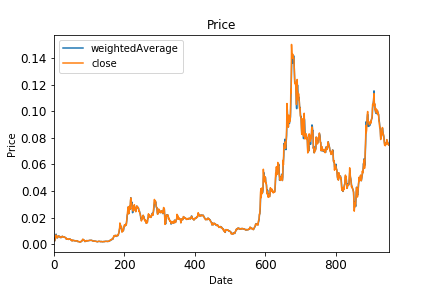

In [43]:
prices = candlesticks[['weightedAverage','close']]
plot(prices, "Price")

In [48]:
print(prices['close'].mean())
print(prices['close'].std())

0.03517242890641428
0.03232938503531059
